# System Diagram

Overview of the system

```mermaid
graph TD
%%    subgraph Input
%%        B[Sent ]
%%    end 
    
    subgraph Process
        A[Web Scraping]
        C[Data Cleaning]
        D[Data Transformation]
        E["Exploratory Data Analysis (EDA)"]
    end
    
    subgraph Output
        F[Statistical Analysis]
        G[Visualization]
%%        H[Export Results]
    end
    
    A --> C
%%    B --> C
    C --> D
    D --> E
    E --> F
    E --> G
%%    F --> H
%%    G --> H
```

# Config and Import

In [31]:
# Import every lib
from utils.thai_lottery_scraper import ThaiLotteryScraper
from utils.data_extractor import extract_zodiac_signs, extract_moon_phase, extract_moon_distance_km

from matplotlib import font_manager
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [ ]:
# Config Thai font for matplotlib
font_manager.fontManager.addfont(os.path.join(
    os.getcwd(), 'assets', 'font', 'Sarabun-Regular.ttf'))
matplotlib.rcParams['font.family'] = 'Sarabun'

# Data Scraping

The data from the website https://www.myhora.com/lottery/stats.aspx?mx=09&vx={year} by using the written utility 

Overview flow chart of the scraping process

```mermaid
graph LR
    A[Start] --> D[Fetch Data]
    D --> E[Parse HTML Content]
    E --> F[Extract Date Info]
    F --> G[Extract Prize Numbers]
    G --> H[Convert Thai Year to Gregorian]
    H --> I[Create Data Dictionary]
    I --> J[Convert to DataFrame]
    J --> L[End]
```

In [3]:
df = ThaiLotteryScraper().scrape_df(30)
df.head()

,date,day,th_month,year,1st_prize,2digit_up,3digit_up,2digit_buttom,"3digit_front,3digit_bottom",3digit_front,3digit_bottom
0,2025-04-16,16,เมษายน,2568,266227,27,227,85,"[254, 413, 474, 760]","[254, 413]","[474, 760]"
1,2025-04-01,1,เมษายน,2568,669687,87,687,36,"[635, 760, 180, 666]","[635, 760]","[180, 666]"
2,2025-03-16,16,มีนาคม,2568,757563,63,563,32,"[595, 927, 309, 457]","[595, 927]","[309, 457]"
3,2025-03-01,1,มีนาคม,2568,818894,94,894,54,"[139, 530, 656, 781]","[139, 530]","[656, 781]"
4,2025-02-16,16,กุมภาพันธ์,2568,847377,77,377,50,"[268, 613, 001, 652]","[268, 613]","[001, 652]"


# Data Quality Validation

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        720 non-null    datetime64[ns]
 1   day                         720 non-null    object        
 2   th_month                    720 non-null    object        
 3   year                        720 non-null    object        
 4   1st_prize                   720 non-null    object        
 5   2digit_up                   720 non-null    object        
 6   3digit_up                   720 non-null    object        
 7   2digit_buttom               720 non-null    object        
 8   3digit_front,3digit_bottom  720 non-null    object        
 9   3digit_front                720 non-null    object        
 10  3digit_bottom               720 non-null    object        
dtypes: datetime64[ns](1), object(10)
memory usage: 62.0+ KB


In [5]:
# Missing data 
df.isnull().sum()

date                          0
day                           0
th_month                      0
year                          0
1st_prize                     0
2digit_up                     0
3digit_up                     0
2digit_buttom                 0
3digit_front,3digit_bottom    0
3digit_front                  0
3digit_bottom                 0
dtype: int64

In [6]:
# Check data Completeness

df_date_diff = df.copy()

df_date_diff.sort_values(by='date', ascending=False, inplace=True)
df_date_diff['days_between_prizes'] = df_date_diff['date'].diff(-1).dt.days
df_date_diff['days_between_prizes'].value_counts()

days_between_prizes
15.0    397
16.0    197
14.0     70
17.0     24
13.0     19
18.0      9
12.0      2
61.0      1
Name: count, dtype: int64

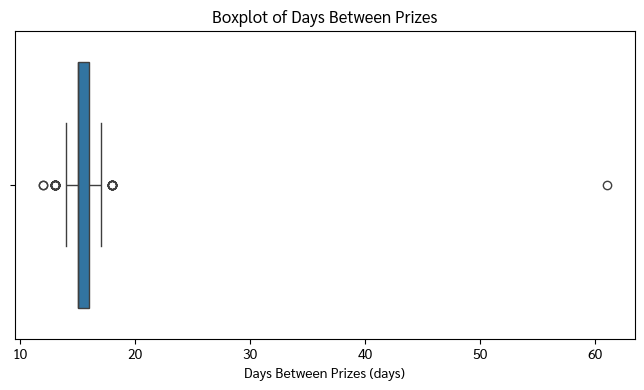

In [7]:
plt.figure(figsize=(8, 4))
sns.boxplot(x="days_between_prizes", data=df_date_diff)
plt.title('Boxplot of Days Between Prizes')
plt.xlabel('Days Between Prizes (days)')
plt.show()

## Checking the outliers (days_between_prizes)

In [8]:
# check the days_between_prizes outliers (61.0)

upper_outlier_value = df_date_diff['days_between_prizes'].quantile(
    0.75) + 1.5 * (df_date_diff['days_between_prizes'].quantile(0.75) - df_date_diff['days_between_prizes'].quantile(0.25))
lower_outlier_value = df_date_diff['days_between_prizes'].quantile(
    0.25) - 1.5 * (df_date_diff['days_between_prizes'].quantile(0.75) - df_date_diff['days_between_prizes'].quantile(0.25))

f"{upper_outlier_value=} {lower_outlier_value=}"

'upper_outlier_value=np.float64(17.5) lower_outlier_value=np.float64(13.5)'

In [9]:
upper_outlier_index = df_date_diff[(
    df_date_diff['days_between_prizes'] > upper_outlier_value)].index
df_date_diff.iloc[upper_outlier_index]

,date,day,th_month,year,1st_prize,2digit_up,3digit_up,2digit_buttom,"3digit_front,3digit_bottom",3digit_front,3digit_bottom,days_between_prizes
30,2024-01-17,17,มกราคม,2567,105979,79,979,61,"[429, 931, 196, 635]","[429, 931]","[196, 635]",18.0
54,2023-01-17,17,มกราคม,2566,812519,19,519,47,"[389, 443, 564, 849]","[389, 443]","[564, 849]",18.0
78,2022-01-17,17,มกราคม,2565,880159,59,159,92,"[731, 786, 119, 529]","[731, 786]","[119, 529]",18.0
102,2021-01-17,17,มกราคม,2564,384395,95,395,15,"[367, 653, 566, 878]","[367, 653]","[566, 878]",18.0
117,2020-06-01,1,มิถุนายน,2563,831567,67,567,24,"[264, 489, 562, 582]","[264, 489]","[562, 582]",61.0
123,2020-01-17,17,มกราคม,2563,491774,74,774,68,"[004, 132, 379, 595]","[004, 132]","[379, 595]",18.0
147,2019-01-17,17,มกราคม,2562,197079,79,079,65,"[206, 412, 127, 660]","[206, 412]","[127, 660]",18.0
171,2018-01-17,17,มกราคม,2561,203823,23,823,50,"[624, 799, 236, 397]","[624, 799]","[236, 397]",18.0
195,2017-01-17,17,มกราคม,2560,145157,57,157,25,"[511, 663, 516, 836]","[511, 663]","[516, 836]",18.0
219,2016-01-17,17,มกราคม,2559,304371,71,371,50,"[031, 532, 743, 786]","[031, 532]","[743, 786]",18.0


In [10]:
max_oulier_index = df_date_diff['days_between_prizes'].idxmax()
df_date_diff.iloc[max_oulier_index:max_oulier_index+2]

,date,day,th_month,year,1st_prize,2digit_up,3digit_up,2digit_buttom,"3digit_front,3digit_bottom",3digit_front,3digit_bottom,days_between_prizes
117,2020-06-01,1,มิถุนายน,2563,831567,67,567,24,"[264, 489, 562, 582]","[264, 489]","[562, 582]",61.0
118,2020-04-01,1,เมษายน,2563,051095,95,095,22,"[285, 430, 191, 364]","[285, 430]","[191, 364]",16.0


In [11]:
lower_outlier_index = df_date_diff[(
    df_date_diff['days_between_prizes'] < lower_outlier_value)].index
df_date_diff.iloc[lower_outlier_index]

,date,day,th_month,year,1st_prize,2digit_up,3digit_up,2digit_buttom,"3digit_front,3digit_bottom",3digit_front,3digit_bottom,days_between_prizes
3,2025-03-01,1,มีนาคม,2568,818894,94,894,54,"[139, 530, 656, 781]","[139, 530]","[656, 781]",13.0
51,2023-03-01,1,มีนาคม,2566,417652,52,652,55,"[577, 919, 748, 984]","[577, 919]","[748, 984]",13.0
75,2022-03-01,1,มีนาคม,2565,061905,05,905,07,"[236, 834, 234, 691]","[236, 834]","[234, 691]",12.0
99,2021-03-01,1,มีนาคม,2564,835538,38,538,73,"[290, 838, 051, 806]","[290, 838]","[051, 806]",13.0
144,2019-03-01,1,มีนาคม,2562,345650,50,650,65,"[137, 999, 830, 837]","[137, 999]","[830, 837]",13.0
192,2017-03-01,1,มีนาคม,2560,978453,53,453,78,"[450, 560, 052, 577]","[450, 560]","[052, 577]",13.0
220,2015-12-30,30,ธันวาคม,2558,008217,17,217,02,"[246, 264, 596, 895]","[246, 264]","[596, 895]",13.0
240,2015-03-01,1,มีนาคม,2558,240237,37,237,34,"[498, 031, 857, 008]","[498, 031]","[857, 008]",13.0
264,2014-03-01,1,มีนาคม,2557,906318,18,318,35,"[116, 537, 753, 798]","[116, 537]","[753, 798]",13.0
288,2013-03-01,1,มีนาคม,2556,976241,41,241,37,"[972, 721, 133, 775]","[972, 721]","[133, 775]",13.0


In [12]:
unusual_lower_outlier_index = df_date_diff[(df_date_diff.date.dt.month == 12) & (
    df_date_diff['days_between_prizes'] < lower_outlier_value)].index
df_date_diff.loc[unusual_lower_outlier_index[0]:unusual_lower_outlier_index[0]+1]

,date,day,th_month,year,1st_prize,2digit_up,3digit_up,2digit_buttom,"3digit_front,3digit_bottom",3digit_front,3digit_bottom,days_between_prizes
220,2015-12-30,30,ธันวาคม,2558,008217,17,217,02,"[246, 264, 596, 895]","[246, 264]","[596, 895]",13.0
221,2015-12-17,17,ธันวาคม,2558,930255,55,255,08,"[140, 250, 094, 638]","[140, 250]","[094, 638]",16.0


# Data Extraction

In [13]:
df['thai_zodiac'] = df['date'].apply(extract_zodiac_signs)
df['dow'] = df['date'].dt.day_name()
df['moon_phase'] = df['date'].apply(extract_moon_phase)
df['moon_category'] = pd.cut(df['moon_phase'],
                             bins=[0, 0.125, 0.375, 0.625, 0.875, 1.0],
                             labels=['เริ่มข้างขึ้น', 'ช่วงข้างขึ้น', 'จันทร์เพ็ญ', 'ช่วงข้างแรม', 'ช่วงข้างแรมแก่'])
df['moon_distance_km'] = df['date'].apply(extract_moon_distance_km)

df.head(3)

,date,day,th_month,year,1st_prize,2digit_up,3digit_up,2digit_buttom,"3digit_front,3digit_bottom",3digit_front,3digit_bottom,thai_zodiac,dow,moon_phase,moon_category,moon_distance_km
0,2025-04-16,16,เมษายน,2568,266227,27,227,85,"[254, 413, 474, 760]","[254, 413]","[474, 760]",Snake,Wednesday,0.921031,ช่วงข้างแรมแก่,404790.676303
1,2025-04-01,1,เมษายน,2568,669687,87,687,36,"[635, 760, 180, 666]","[635, 760]","[180, 666]",Snake,Tuesday,0.096285,เริ่มข้างขึ้น,360971.402401
2,2025-03-16,16,มีนาคม,2568,757563,63,563,32,"[595, 927, 309, 457]","[595, 927]","[309, 457]",Snake,Sunday,0.973304,ช่วงข้างแรมแก่,404587.646588


Save to csv as a backup file.

In [14]:
df.to_csv('lottery_data.csv', index=False)

# EDA

In [15]:
df.describe()

,date,moon_phase,moon_distance_km
count,720,720.000000,720.000000
mean,2010-03-17 00:28:00,0.501487,384946.832206
min,1995-03-16 00:00:00,0.000261,357228.257555
25%,2002-09-12 06:00:00,0.151557,370759.757869
50%,2010-03-08 12:00:00,0.502317,385650.258076
75%,2017-09-04 18:00:00,0.854666,399957.226362
max,2025-04-16 00:00:00,0.999684,406649.500592
std,NaN,0.353478,15160.461728


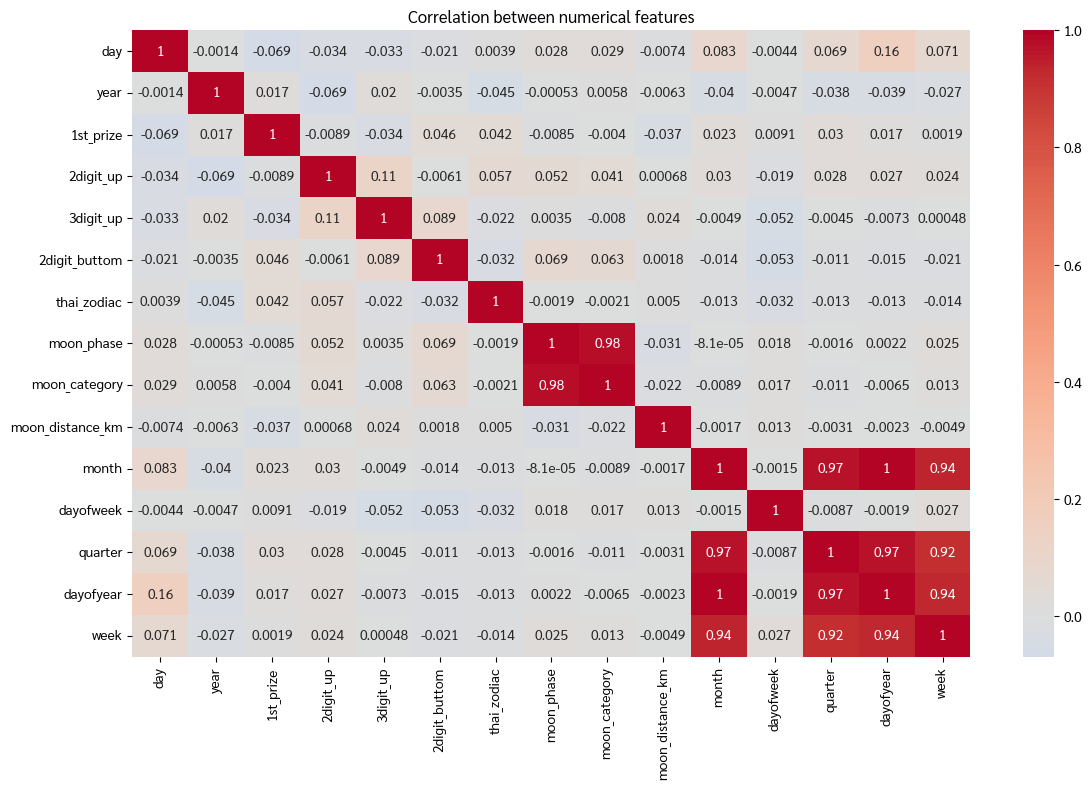

In [16]:
# Extract time features
df_time = df.copy()

df_time['year'] = df_time['date'].dt.year
df_time['month'] = df_time['date'].dt.month
df_time['day'] = df_time['date'].dt.day
df_time['dayofweek'] = df_time['date'].dt.dayofweek
df_time['quarter'] = df_time['date'].dt.quarter
df_time['dayofyear'] = df_time['date'].dt.dayofyear
df_time['week'] = df_time['date'].dt.isocalendar().week
df_time['thai_zodiac'] = df_time['thai_zodiac'].astype('category').cat.codes

df_time['moon_phase'] = df_time['moon_phase'].astype('category').cat.codes
df_time['moon_category'] = df_time['moon_category'].astype('category').cat.codes

df_time['1st_prize'] = df_time['1st_prize'].astype(int)
df_time['2digit_up'] = df_time['2digit_up'].astype(int)
df_time['3digit_up'] = df_time['3digit_up'].astype(int)
df_time['2digit_buttom'] = df_time['2digit_buttom'].astype(int)


# Calculate correlations
# {'pearson', 'kendall', 'spearman'}
correlation_matrix = df_time.corr(numeric_only=True, method='pearson')

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between numerical features')
plt.tight_layout()

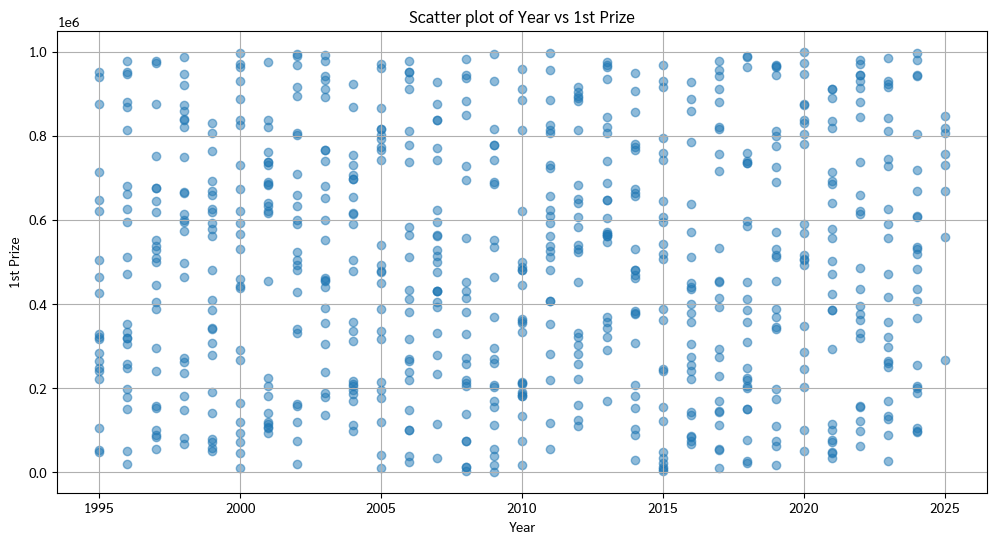

In [17]:
# Scatter plot year vs 1st prize
plt.figure(figsize=(12, 6))
plt.scatter(df_time['year'], df_time['1st_prize'].astype(int), alpha=0.5)
plt.title('Scatter plot of Year vs 1st Prize')
plt.xlabel('Year')
plt.ylabel('1st Prize')
plt.grid()
plt.show()

In [18]:
# Define dedicated pastel colors to numbers
number_colors = {
    '0': '#80B3FF',  # deeper pastel blue
    '1': '#FFB380',  # deeper pastel orange
    '2': '#80FF80',  # deeper pastel green
    '3': '#FF8080',  # deeper pastel red
    '4': '#CC99FF',  # deeper pastel purple
    '5': '#BFA68C',  # deeper pastel brown
    '6': '#FF80D4',  # deeper pastel pink
    '7': '#BFBFBF',  # deeper pastel grey
    '8': '#A6FF80',  # deeper pastel light green
    '9': '#80E5FF'   # deeper pastel light blue
}

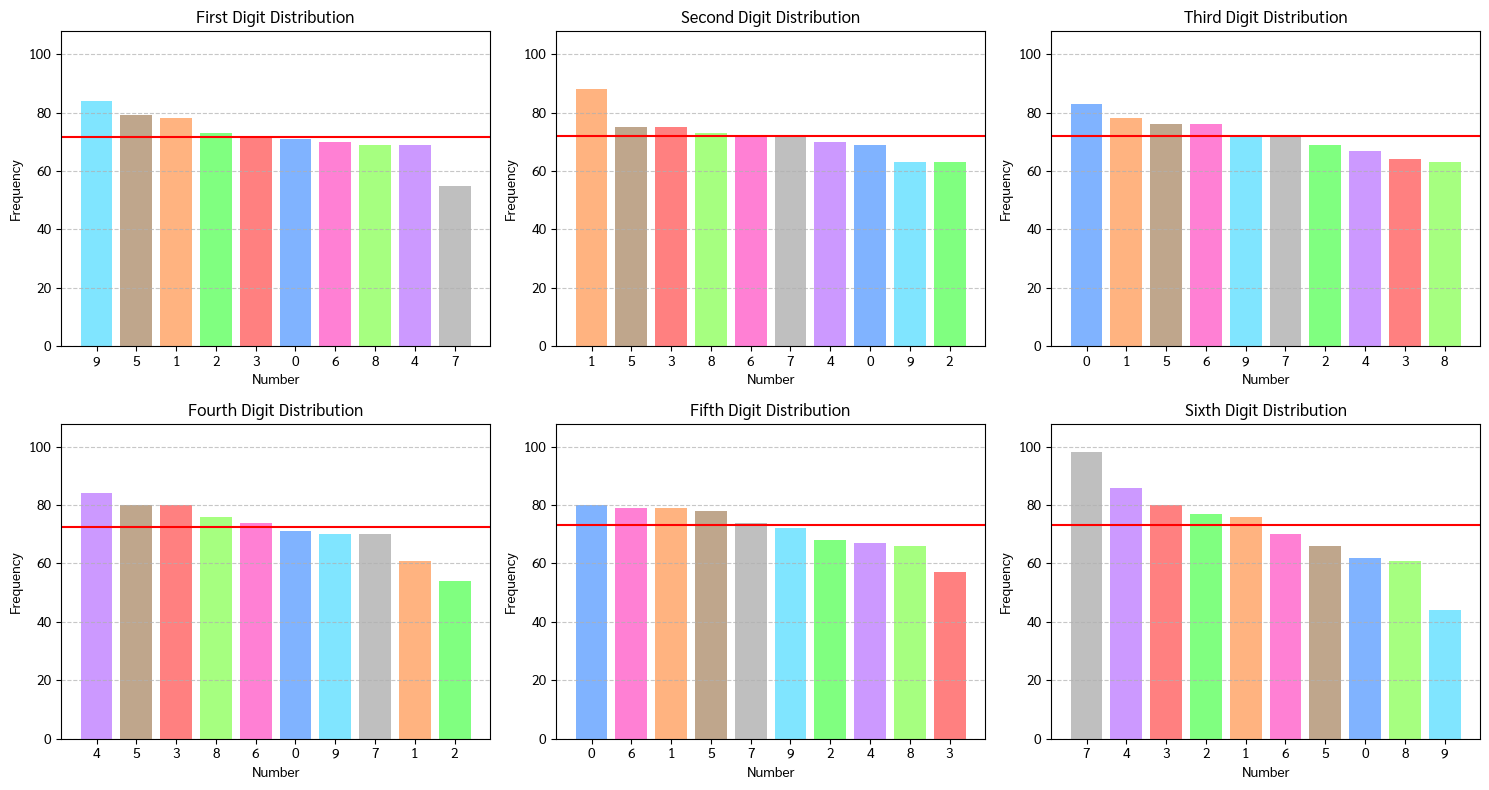

In [19]:
# Extract each digit of the first prize number
df['1st_prize'] = df['1st_prize'].astype(str).str.zfill(6)  # Ensure 6 digits with leading zeros

plt.figure(figsize=(15, 8))
positions = [(0, 'First'), (1, 'Second'), (2, 'Third'),
             (3, 'Fourth'), (4, 'Fifth'), (5, 'Sixth')]

for i, (pos, label) in enumerate(positions):
    plt.subplot(2, 3, i+1)
    
    digit_var_name = f'win_digit{i+1}'
    globals()[digit_var_name] = df['1st_prize'].str[pos]
    
    digit_counts = globals()[digit_var_name].value_counts()
    
    # Use number_colors for each bar based on the digit
    colors = [number_colors[str(digit)] for digit in digit_counts.index]
    plt.bar(digit_counts.index, digit_counts.values, color=colors)
    
    median_value = digit_counts.median()
    plt.axhline(y=median_value, color='r', linestyle='-',
                label=f'Median: {median_value:.0f}')
    
    plt.title(f'{label} Digit Distribution')
    plt.xlabel('Number')
    plt.ylabel('Frequency')
    plt.xticks(range(10))
    
    # Set consistent y-axis limits
    max_frequency = max(df['1st_prize'].str[pos].value_counts().max() for pos in range(6))
    plt.ylim(0, max_frequency * 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

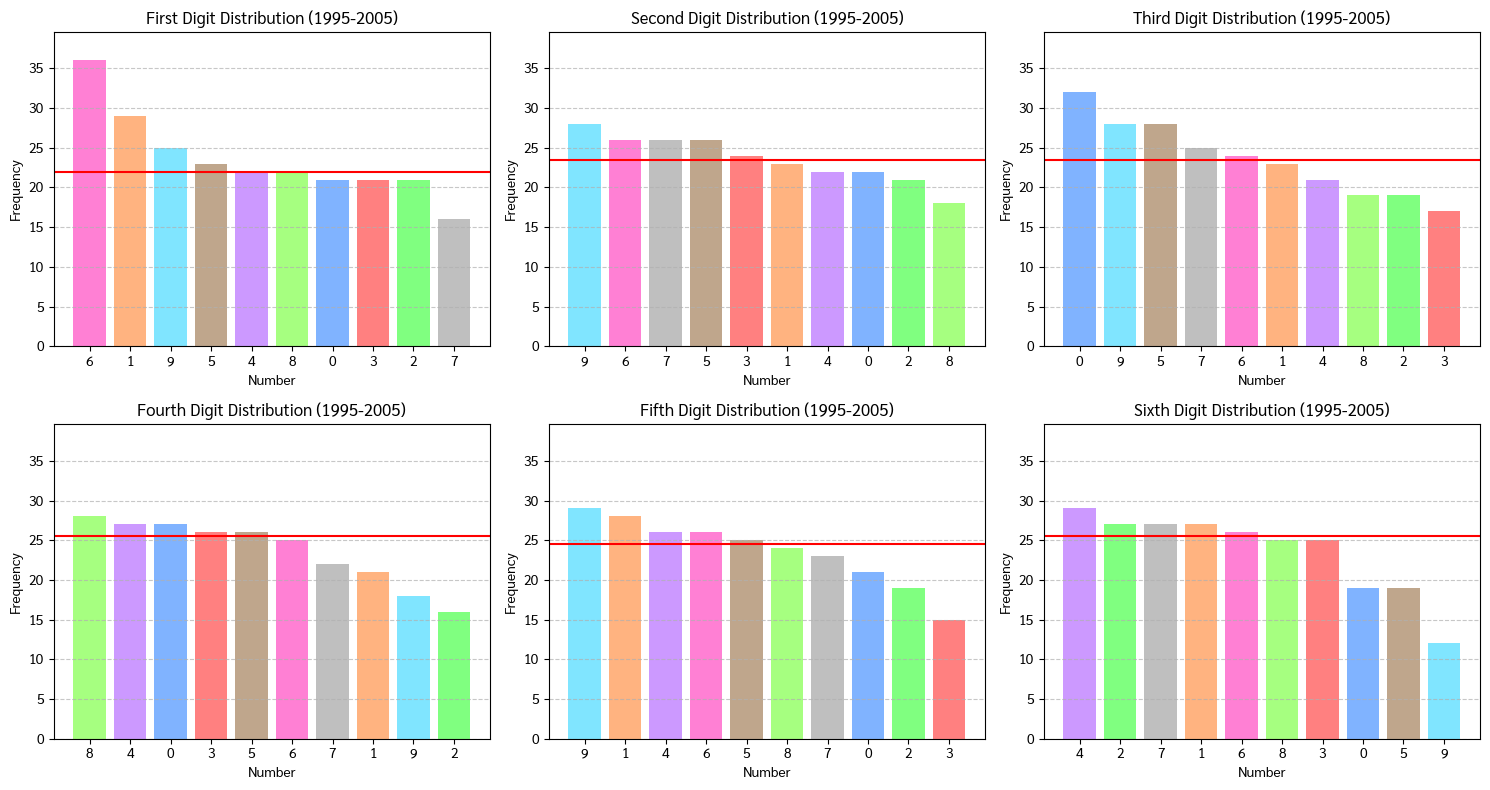

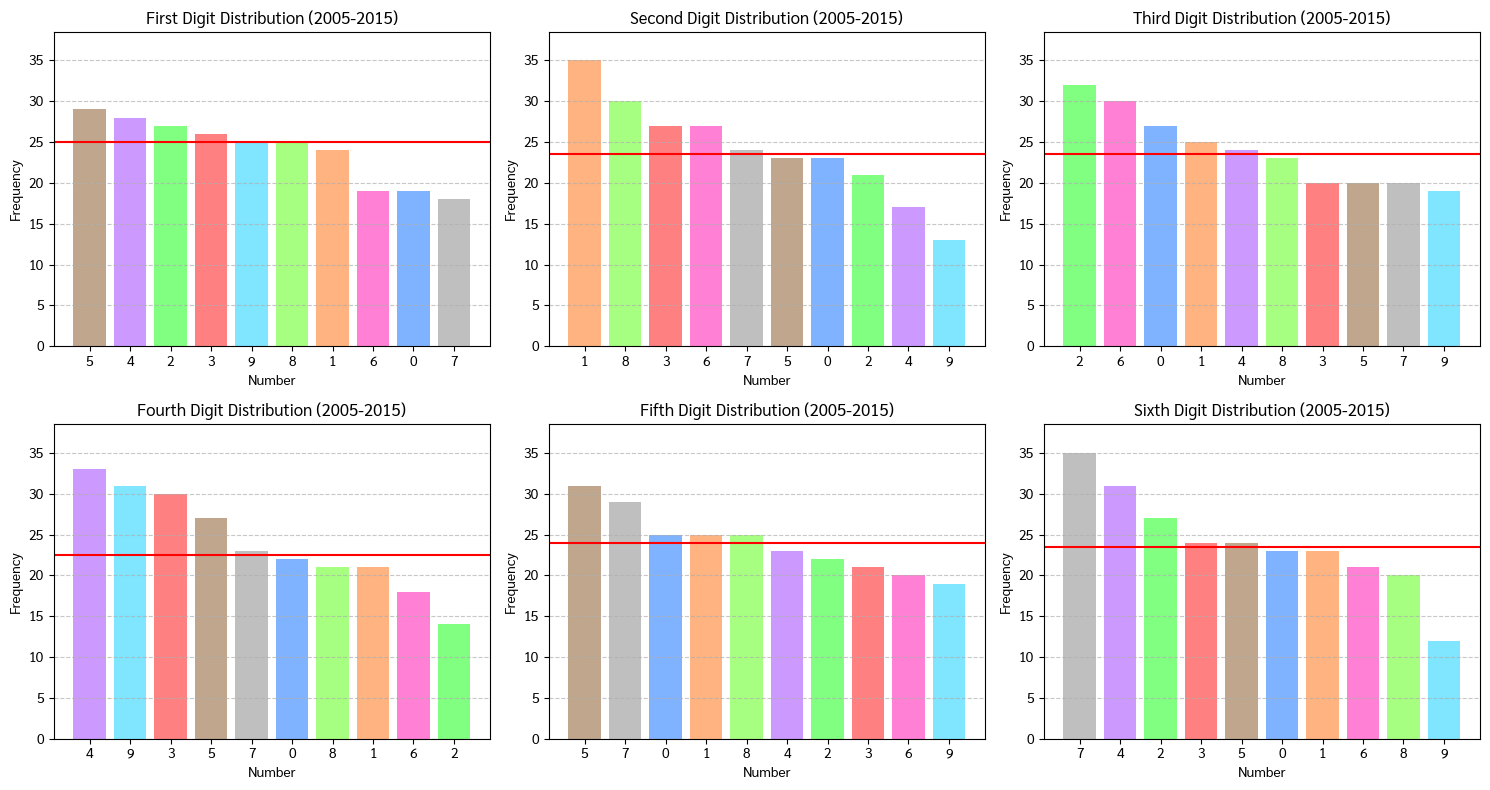

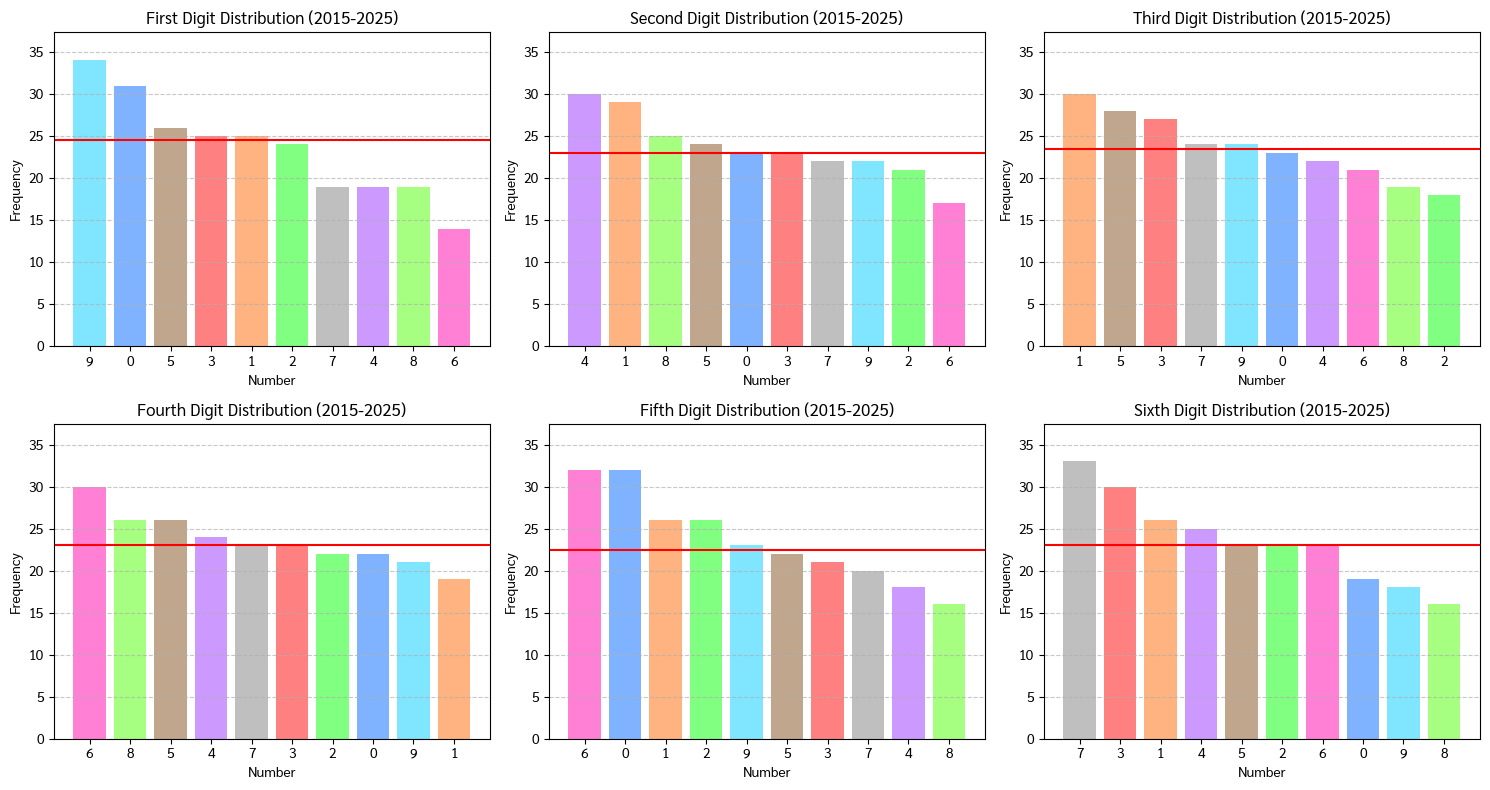

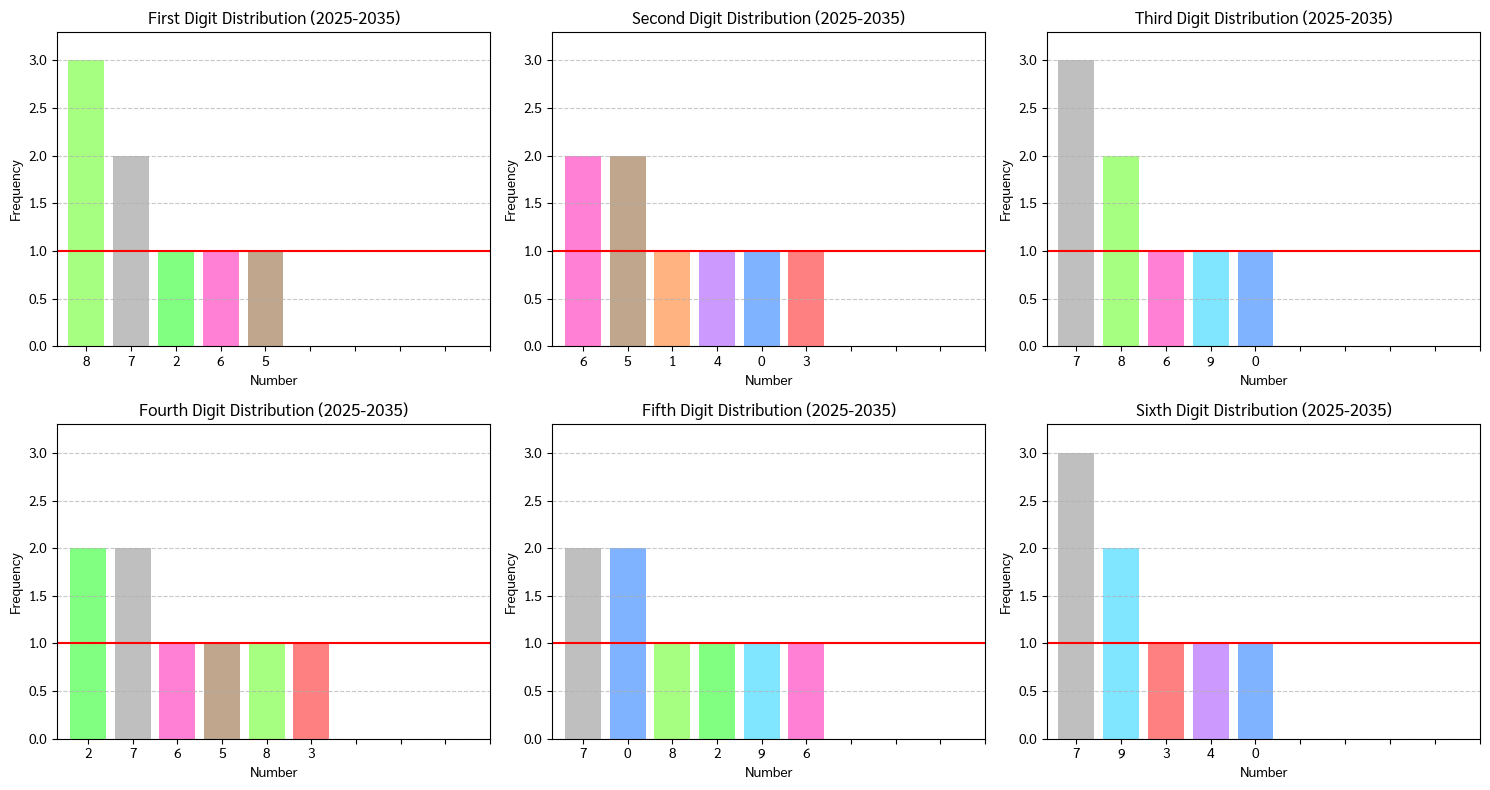

In [20]:
years = []
filtered_df = df.copy()
every_Xyear = 10

for i in range(0, (filtered_df.date.dt.year.max() - filtered_df.date.dt.year.min()) // every_Xyear + 1):
    years.append(filtered_df.date.dt.year.min() + every_Xyear*i)

for year in years:
    plt.figure(figsize=(15, 8))
    filtered_df_year = filtered_df[(filtered_df.date.dt.year >= year) & (
        filtered_df.date.dt.year < year + every_Xyear)]

    for i, (pos, label) in enumerate(positions):
        plt.subplot(2, 3, i+1)

        digit_var_name = f'win_digit{i+1}'
        globals()[digit_var_name] = filtered_df_year['1st_prize'].str[pos]
        digit_counts = globals()[digit_var_name].value_counts()

        # Use number_colors for bars
        colors = [number_colors[str(digit)] for digit in digit_counts.index]
        plt.bar(digit_counts.index, digit_counts.values, color=colors)

        median_value = digit_counts.median()
        plt.axhline(y=median_value, color='r', linestyle='-',
                   label=f'Median: {median_value:.0f}')

        plt.title(f'{label} Digit Distribution ({year}-{year + every_Xyear})')
        plt.xlabel('Number')
        plt.ylabel('Frequency')
        plt.xticks(range(10))

        max_frequency = max(filtered_df_year['1st_prize'].str[pos].value_counts().max() for pos in range(6))
        plt.ylim(0, max_frequency * 1.1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

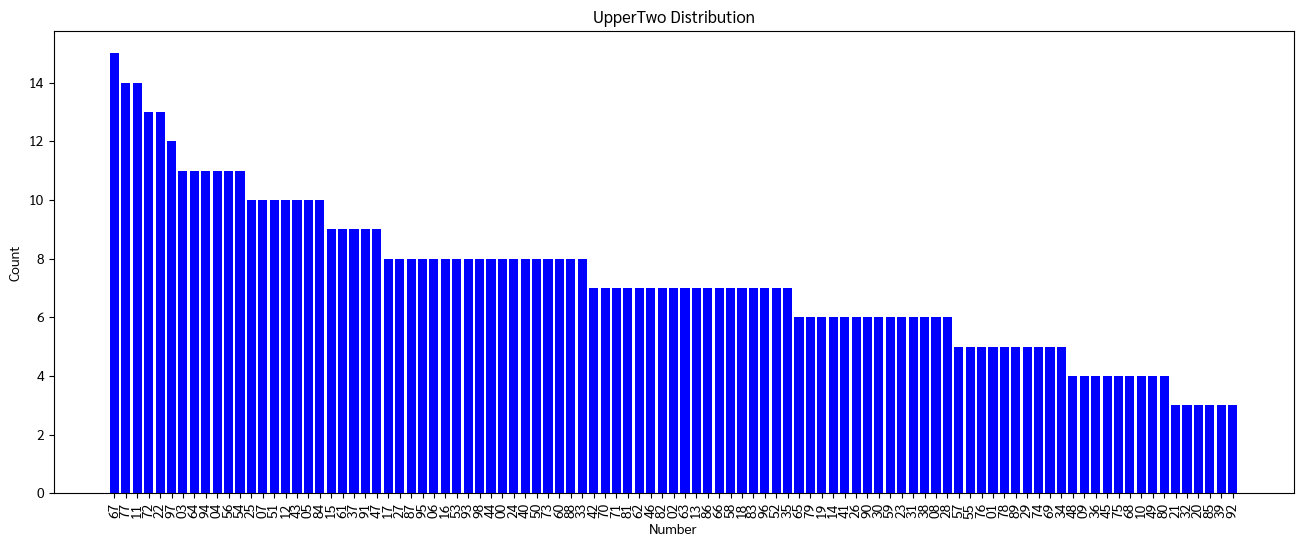

In [21]:
upper2 = df['2digit_up'].astype(str).str.zfill(2)

upper2.value_counts()
plt.figure(figsize=(16, 6))
plt.bar(upper2.value_counts().index,
        upper2.value_counts().values, color='blue')
plt.title('UpperTwo Distribution')
plt.xlabel('Number')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

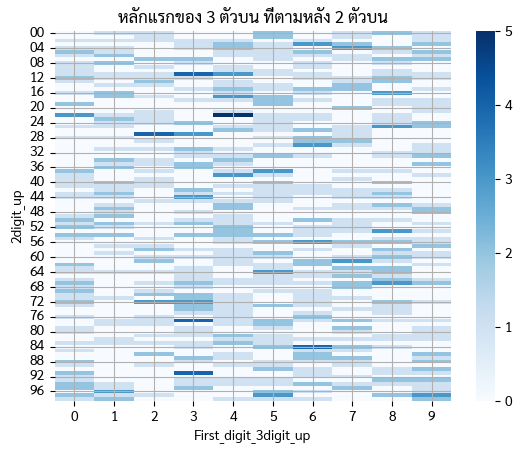

In [22]:
filtered_df = df.copy()

filtered_df['First_digit_3digit_up'] = filtered_df['3digit_up'].str[0]

# print(filtered_df[['2digit_up', '3digit_up', 'First_digit_3digit_up']])

plt.title('หลักแรกของ 3 ตัวบน ที่ตามหลัง 2 ตัวบน')
plt.xlabel('2ตัวบน')
plt.ylabel('หลักแรกของ 3ตัวบน')
plt.grid()

heatmap_data = pd.crosstab(
    filtered_df['2digit_up'], filtered_df['First_digit_3digit_up'])

sns.heatmap(heatmap_data, fmt='d', cmap='Blues')
plt.show()

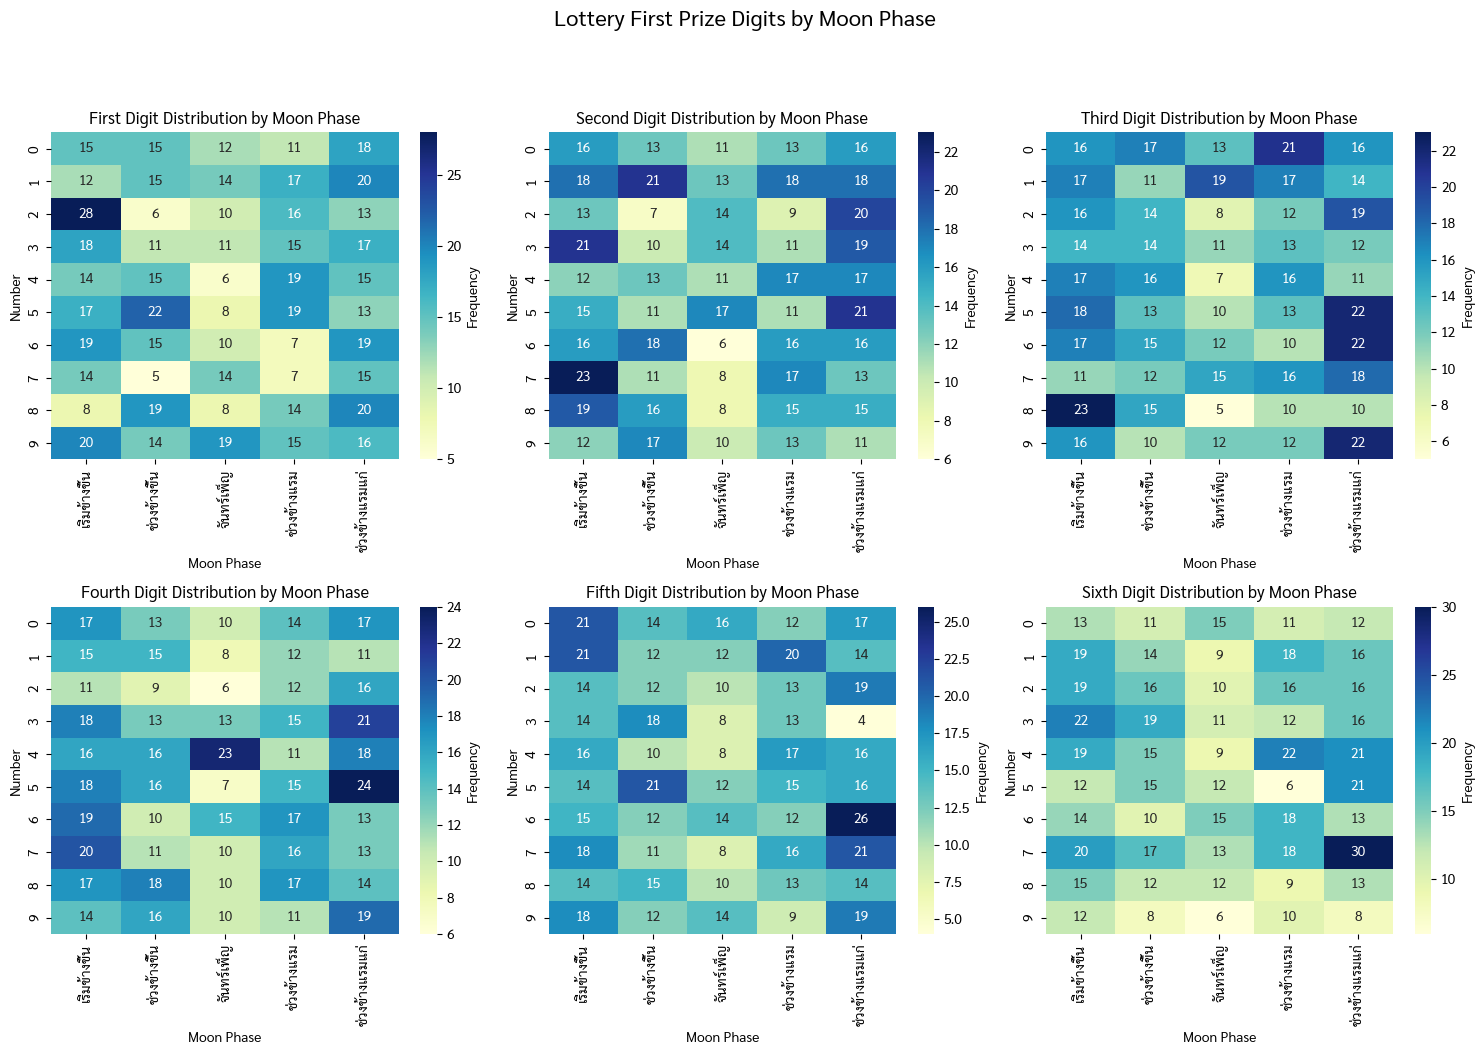

In [23]:
# Ensure we have the digit columns in the dataframe
for i, (pos, label) in enumerate(positions):
    df[f'win_digit{i+1}'] = df['1st_prize'].str[pos]
    # print(df[f'win_digit{i+1}'])

# Plot the distribution of first prize digits by moon phase
plt.figure(figsize=(15, 10))

# For each digit position
for i, (pos, label) in enumerate(positions):
    plt.subplot(2, 3, i+1)

    # Create a pivot table to show frequency of each digit by moon phase
    pivot = pd.crosstab(df[f'win_digit{i+1}'], df['moon_category'])

    # Plot as a heatmap
    sns.heatmap(pivot, cmap="YlGnBu", annot=True,
                fmt='.0f', cbar_kws={'label': 'Frequency'})

    plt.title(f'{label} Digit Distribution by Moon Phase')
    plt.xlabel('Moon Phase')
    plt.ylabel('Number')
    plt.tight_layout()

plt.suptitle('Lottery First Prize Digits by Moon Phase', fontsize=16, y=1.05)
plt.tight_layout()

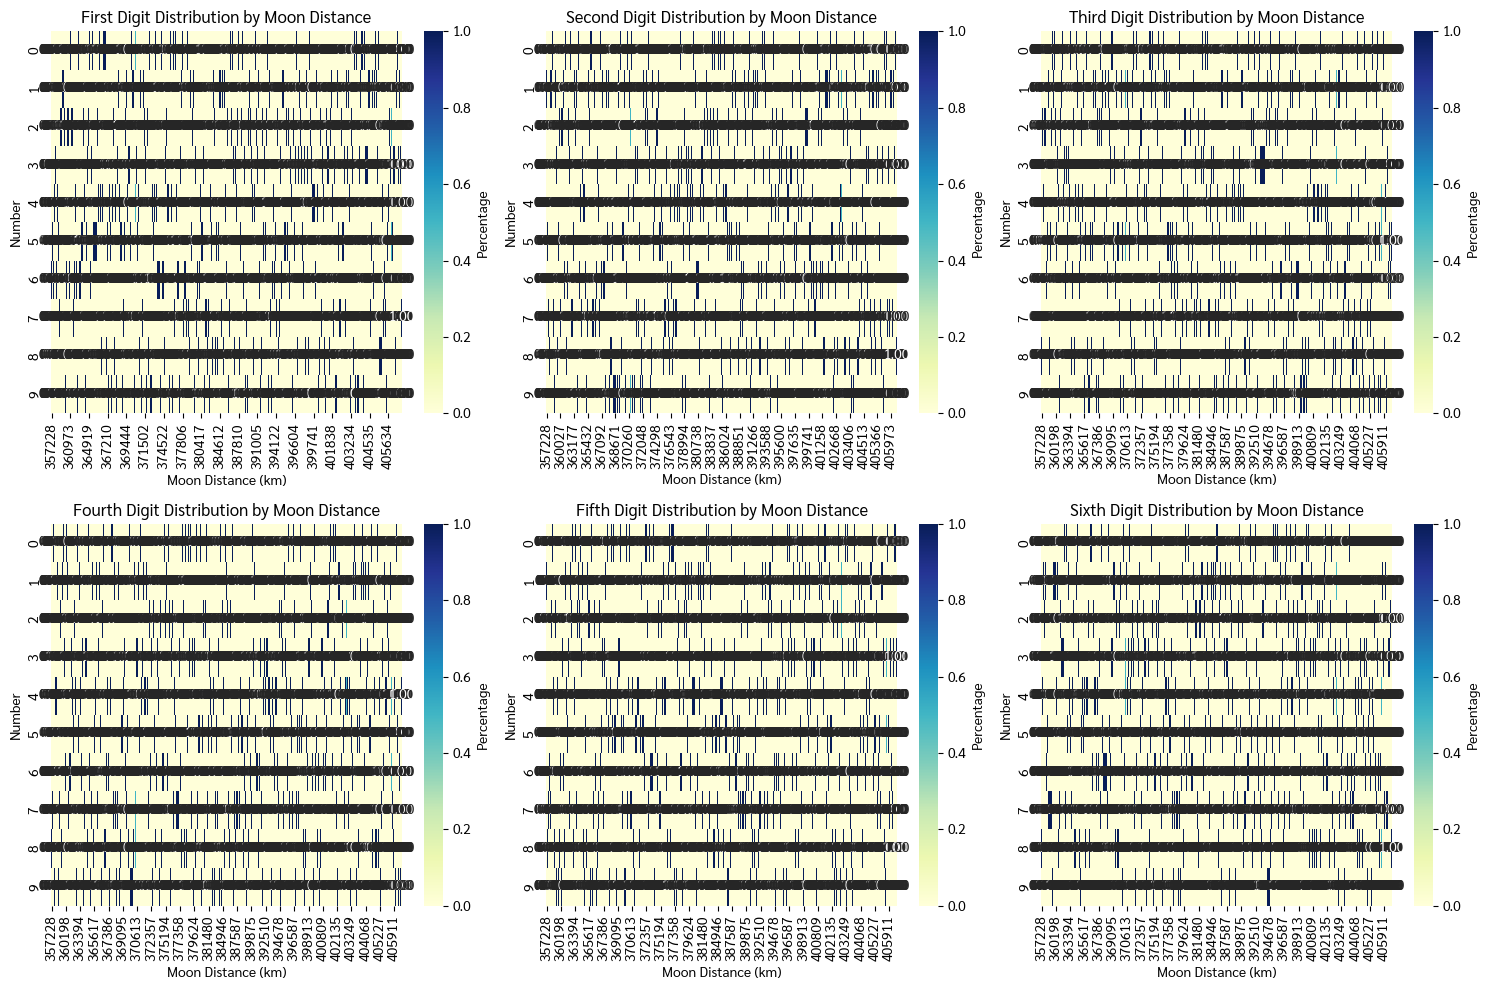

In [24]:
df_temp = df.copy()
df_temp['moon_distance_km'] = df_temp['moon_distance_km'].astype(int)

plt.figure(figsize=(15, 10))

for i, (pos, label) in enumerate(positions):
    plt.subplot(2, 3, i+1)
    # Create a pivot table but normalize each column to show percentages
    pivot_data = df_temp.pivot_table(
        index=f'win_digit{i+1}', columns='moon_distance_km', values='1st_prize', aggfunc='count', fill_value=0)
    # Normalize the data (each column will sum to 1)
    normalized_pivot = pivot_data.div(pivot_data.sum(axis=0), axis=1)
    sns.heatmap(normalized_pivot, cmap="YlGnBu", annot=True,
                fmt='.2f', cbar_kws={'label': 'Percentage'})

    plt.title(f'{label} Digit Distribution by Moon Distance')
    plt.xlabel('Moon Distance (km)')
    plt.ylabel('Number')
    plt.tight_layout()

<Figure size 1200x600 with 0 Axes>

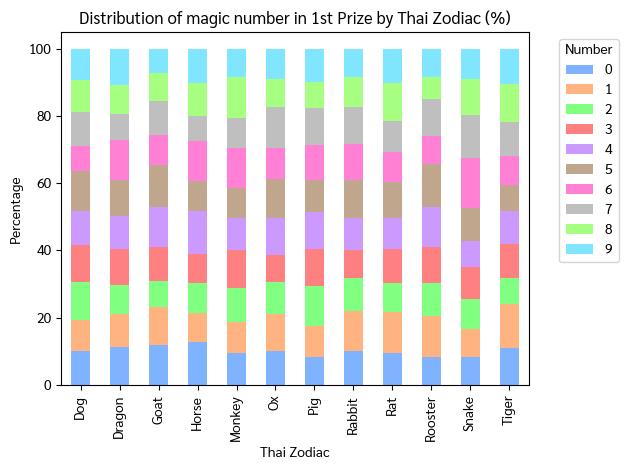

In [25]:
# Merge zodiac data with first digit frequency
df_temp = df.copy()
df_temp['1st_prize_lst'] = df_temp['1st_prize'].apply(lambda x: list(str(x)))
df_temp = df_temp.explode('1st_prize_lst')
zodiac_digit_counts = df_temp.groupby(['thai_zodiac', '1st_prize_lst']).size().reset_index(name='count')

# Calculate percentages within each zodiac sign
zodiac_totals = zodiac_digit_counts.groupby('thai_zodiac')['count'].sum()
zodiac_digit_counts['percentage'] = zodiac_digit_counts.apply(
    lambda x: (x['count'] / zodiac_totals[x['thai_zodiac']]) * 100, axis=1)

# Create pivot table with percentages for visualization
pivot_df = zodiac_digit_counts.pivot(index='thai_zodiac', columns='1st_prize_lst', values='percentage')

# Plot
plt.figure(figsize=(12, 6))
pivot_df.plot(kind='bar', stacked=True, color=[number_colors[str(i)] for i in range(10)])
plt.title('Distribution of magic number in 1st Prize by Thai Zodiac (%)')
plt.xlabel('Thai Zodiac')
plt.ylabel('Percentage')
plt.legend(title='Number', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

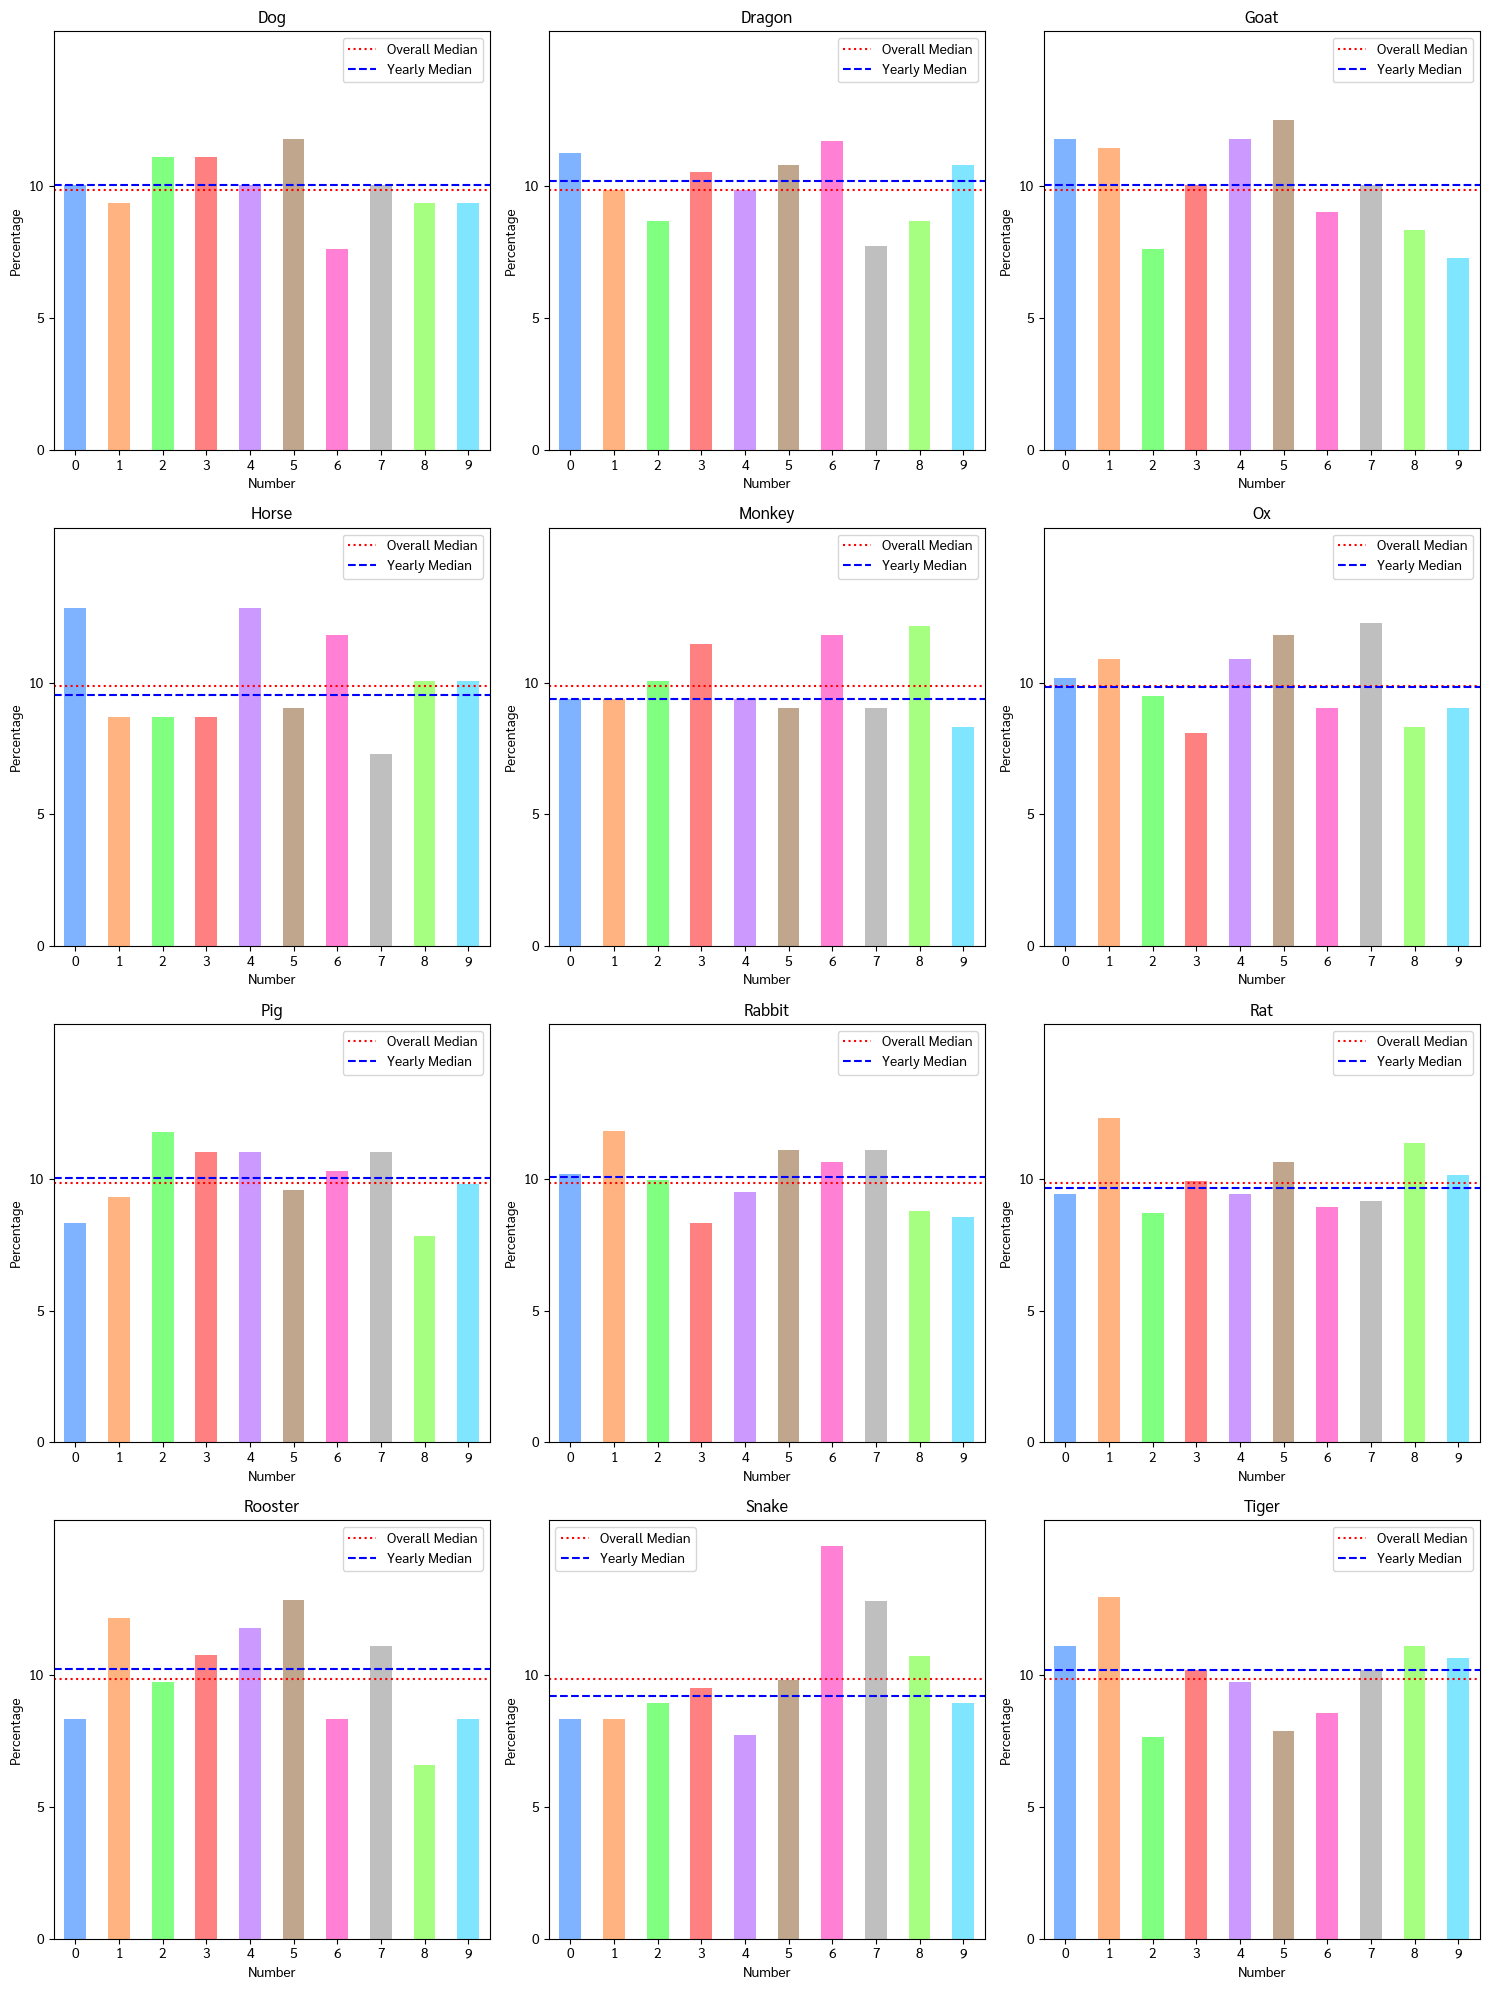

In [26]:
# Calculate the median percentage for each number across all zodiac signs
median_by_number = pivot_df.median()

# Create a figure with subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
axes = axes.ravel()

# Plot each zodiac sign in a separate subplot
for idx, zodiac in enumerate(pivot_df.index):
    data = pivot_df.loc[zodiac]
    
    # Plot bars
    bars = data.plot(kind='bar', ax=axes[idx], color=[number_colors[str(i)] for i in range(10)])
    
    # Add overall median line
    axes[idx].axhline(y=median_by_number.mean(), color='red', linestyle=':', label='Overall Median')
    
    # Add yearly median line
    yearly_median = data.median()
    axes[idx].axhline(y=yearly_median, color='blue', linestyle='--', label='Yearly Median')
    
    axes[idx].set_title(f'{zodiac}')
    axes[idx].set_xlabel('Number')
    axes[idx].set_ylabel('Percentage')
    axes[idx].tick_params(axis='x', rotation=0)
    
    # Add legend for both lines
    axes[idx].legend(['Overall Median', 'Yearly Median'])

# Set y-axis limits to be the same for all subplots
y_max = pivot_df.values.max() + 1
for ax in axes:
    ax.set_ylim(0, y_max)
    ax.set_yticks(range(0, int(y_max), 5))
    
plt.tight_layout()
plt.show()

In [27]:
import pandas as pd

df_1prize = pd.DataFrame(df['1st_prize'].apply(lambda x: [{"digit":i+1,"value":digit} for i, digit in enumerate(str(x))]).explode().reset_index(drop=True).to_list())
df_1prize.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   digit   4320 non-null   int64 
 1   value   4320 non-null   object
dtypes: int64(1), object(1)
memory usage: 67.6+ KB


In [28]:
df_1prize.groupby('digit')['value'].value_counts().sort_values(ascending=False).reset_index().to_csv('1prize_digit_value_counts.csv', index=False, header=False)

In [29]:

df_1prize = pd.DataFrame(df['1st_prize'].apply(lambda x: [
                         {"value [i]": x[i], "value [i+1]": x[i+1]} for i in range(len(x)-1)]).explode().reset_index(drop=True).to_list())
df_1prize.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   value [i]    3600 non-null   object
 1   value [i+1]  3600 non-null   object
dtypes: object(2)
memory usage: 56.4+ KB


In [30]:
df_1prize.groupby('value [i]')['value [i+1]'].value_counts().sort_values(ascending=False).reset_index(
).to_csv('1prize_what_next.csv', index=False, header=False)